In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots, UnicodePlots
using JuAFEM
const JFM = JuAFEM

JuAFEM

In [103]:
# Parameters
grid_resolution        = 100
quadrature_order       = 1
selected_ev            = 2;      # which Eigenvector to choose
ϵ                      = 0.1     # perturbation
t₀                      = 0.6;    # parameter value corresponding to ϵ=0
δ                      = 1e-2
ξ                      = 0

0

In [75]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + 1*p], tolerance=1e-5)[end] + 0 .*[p*0.2, p*0.2]

T (generic function with 1 method)

In [41]:
Tdot(x) = Main.CoherentStructures.parameter_autodiff(T, x, 0)
exact_Tdot(x) = rot_double_gyre(T(x,0), nothing, t₀) #[0.2, 0.2]#

exact_Tdot (generic function with 1 method)

In [42]:
LL, UR = (0.0+δ, 0.0+δ), (1.0-δ, 1.0-δ)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [43]:
M = assembleMassMatrix(ctx);

In [44]:
@time D⁰ = assembleStiffnessMatrix(ctx)
@time D¹ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,0))
K = 0.5(D⁰+D¹);
nothing

  0.009285 seconds (19.76 k allocations: 15.080 MiB)
  0.313756 seconds (819.82 k allocations: 131.546 MiB, 8.92% gc time)


In [45]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
u₀ = u₀[:,selected_ev]
u₀ = u₀ ./ (u₀'*M*u₀)       #L2 normalization
λ₀ = λ₀[selected_ev]

  0.878691 seconds (2.38 k allocations: 90.581 MiB, 2.39% gc time)


-49.12289157057165

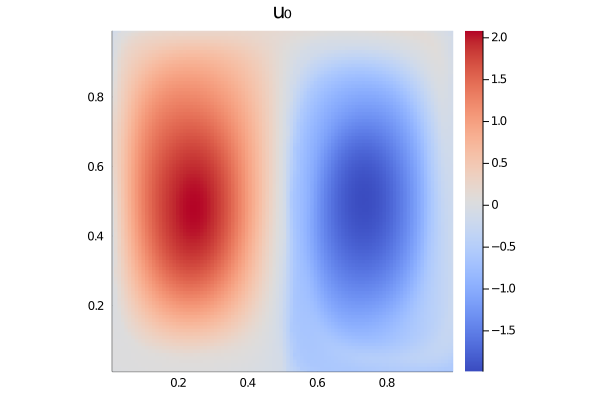

In [47]:
original = plot_u(ctx, u₀, grid_resolution, grid_resolution, colorbar=:left, color=:coolwarm, title="u₀")

In [104]:
num_real_points = ctx.n
flow_map_images = zeros(Vec{2}, num_real_points)
for i in 1:num_real_points
    flow_map_images[i] = Vec{2}(T(ctx.grid.nodes[i].x, 0) + ξ*(2*rand(2).-1))
    end
flow_map_t(j) = flow_map_images[j]
nothing

In [105]:
new_ctx,new_bdata,_ = Main.CoherentStructures.adaptiveTOFutureGrid(ctx,flow_map_t, 
                        flow_map_mode=1,quadrature_order=quadrature_order);

In [106]:
W = zeros(JFM.getdim(ctx.grid),getnnodes(ctx.grid))
for i in 1:num_real_points
    W[:,i] = exact_Tdot(ctx.grid.nodes[i].x)    
end

In [107]:
translation_table_old = Main.CoherentStructures.node_to_bcdof(ctx,BoundaryData())
translation_table_new = Main.CoherentStructures.bcdof_to_node(new_ctx,new_bdata)
nothing

In [108]:
cv = JFM.CellScalarValues(new_ctx.qr, new_ctx.ip, new_ctx.ip_geom)
dh = new_ctx.dh
L = JFM.create_sparsity_pattern(dh)
a_L = JFM.start_assemble(L)
dofs = zeros(Int, JFM.ndofs_per_cell(dh))
n = JFM.getnbasefunctions(cv)
Le = zeros(n, n)
for cell in JFM.CellIterator(dh)
    fill!(Le, 0)
    JFM.reinit!(cv, cell)
    for q in 1:JFM.getnquadpoints(cv)
        dΩ = JFM.getdetJdV(cv, q)
        for i in 1:n
            ∇φᵢ = JFM.shape_gradient(cv, q, i)
            for j in 1:n
                ∇φⱼ = JFM.shape_gradient(cv, q, j)
                for k in 1:n                    
                    ∇φₖ = JFM.shape_gradient(cv, q, k)
                    k_in_old_grid = translation_table_new[JFM.celldofs(cell)[k]]
                    #k_in_bdof = translation_table_old[k_in_old_grid]
                    w = W[:,k_in_old_grid]
                    #print(cell.coords[k],"\n")
                    #print(T(ctx.grid.nodes[k_in_bdof].x,0),"\n")
                    Le[i,j] += (∇φᵢ ⋅ w) * (∇φₖ ⋅ ∇φⱼ) * dΩ  
                end
            end
        end
    end
    JFM.celldofs!(dofs, cell)   #hierrauf schauen
    JFM.assemble!(a_L, dofs, Le)#hierrein schauen
end
nothing

In [109]:
findmax(L)

(1.9929469926960783e6, CartesianIndex(9167, 9167))

In [110]:
L

10000×10000 SparseArrays.SparseMatrixCSC{Float64,Int64} with 69802 stored entries:
  [1    ,     1]  =  -8.53091
  [2    ,     1]  =  10.7007
  [3    ,     1]  =  -14.8855
  [426  ,     1]  =  4.68954
  [428  ,     1]  =  -1.30891
  [4348 ,     1]  =  5.82312
  [4352 ,     1]  =  -11.2285
  [4382 ,     1]  =  14.7404
  [1    ,     2]  =  10.8919
  [2    ,     2]  =  -17.6502
  [3    ,     2]  =  17.2632
  [4364 ,     2]  =  7.51548
  ⋮
  [9999 ,  9998]  =  11.2911
  [3065 ,  9999]  =  -0.0996417
  [7728 ,  9999]  =  -4.45762
  [7729 ,  9999]  =  4.06791
  [9983 ,  9999]  =  7.02531
  [9998 ,  9999]  =  11.2289
  [9999 ,  9999]  =  -17.7649
  [7726 , 10000]  =  17.6193
  [7729 , 10000]  =  21.3597
  [7730 , 10000]  =  1.91803
  [9983 , 10000]  =  3.95854
  [9984 , 10000]  =  -4.32896
  [10000, 10000]  =  -40.5266

In [111]:
I, J, V = Main.CoherentStructures.findnz(L)
I .= translation_table_new[I]
J .= translation_table_new[J]
L_new = Main.CoherentStructures.sparse(I,J,V,size(L,1),size(L,2))
L_new = 0.5*(L_new+L_new')
nothing

In [114]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L_new*u₀ ; 0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.201624 seconds (74 allocations: 62.927 MiB)


34.100846392883206

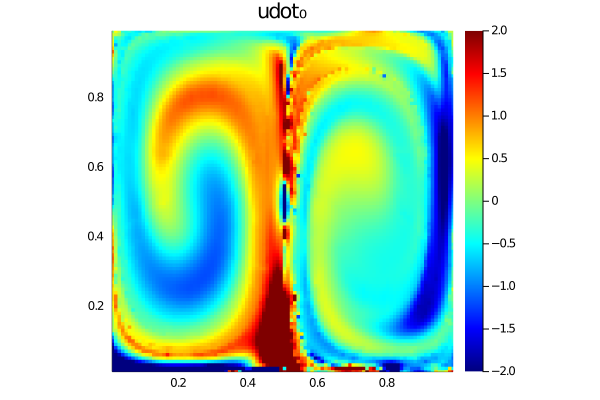

In [115]:
derivative = plot_u(ctx, max.(-2,min.(2,u_dot)), grid_resolution, grid_resolution, colorbar=:left, color=:jet, title="udot₀")

In [21]:
# calculate the exact uϵ
D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,ϵ))
Kϵ = 0.5(D⁰+D¹ϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
uϵ = uϵ[:,selected_ev]
uϵ = uϵ ./ (uϵ'*M*uϵ)        #L2 normalization
λϵ = λϵ[selected_ev]

-55.9498757317992

In [22]:
λ₀ + ϵ*λ_dot

-53.6271448295423

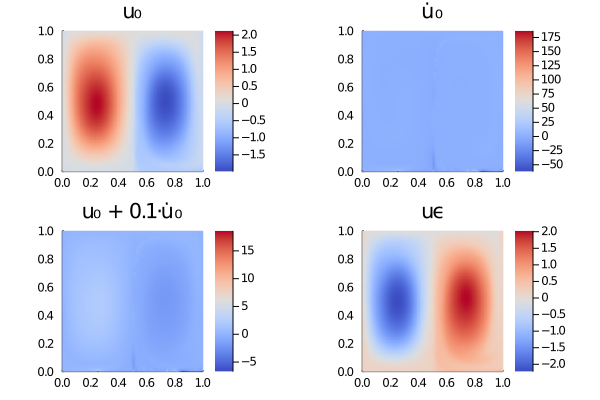

In [23]:
original      = plot_u(ctx, u₀,           grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="u₀")
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="u̇ ₀")
extrapolated  = plot_u(ctx,  u₀ + ϵ*u_dot, grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="u₀ + $(ϵ)⋅u̇ ₀")
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="uϵ")
Plots.plot(original,derivative,extrapolated,exact)

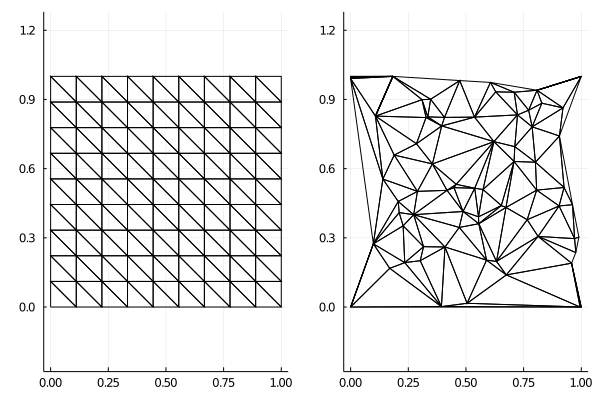

In [24]:
ctx_plot, _ = regularTriangularGrid((10, 10), LL, UR, quadrature_order = quadrature_order)
flow_map_t(j) = Vec{2}(T(ctx_plot.grid.nodes[j].x,0))
new_ctx_plot,_,_ = Main.CoherentStructures.adaptiveTOFutureGrid(ctx_plot,flow_map_t,flow_map_mode=1)

original_grid = Main.CoherentStructures.plot_grid(ctx_plot)
adapted_grid = Main.CoherentStructures.plot_grid(new_ctx_plot)
Plots.plot(original_grid,adapted_grid)